In [664]:
import polars as pl
import numpy as np
from typing import List

def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # 观测噪声协方差（越小越信）
        Q: float = 1e-5   # 过程噪声协方差（越小越稳）
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)      # 估计值
    P = np.zeros(n)          # 估计误差协方差
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # 预测更新
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # 观测更新
        K = P_minus / (P_minus + R)  # 卡尔曼增益
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)

# 判断序列是收敛、发散还是混沌系统：
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)

def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1 : i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)

def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series

def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")


def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")

def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")

def rolling_skew_shift_expr(col: str, window: int) -> pl.Expr:
    return (
        (pl.col(col).rolling_skew(window) - pl.col(col).rolling_skew(window).shift(1))
        .alias(f"{col}_skew_shift_{window}")
    )

def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")

def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")

def spread_product_expr(a: str, b: str) -> pl.Expr:
    return ((pl.col(a) - pl.col(b)) * (pl.col(a) + pl.col(b))).alias(f"{a}_SPREAD_X_MAG_{b}")

def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['price', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
            rolling_skew_shift_expr(col, window),
        ])

    return single_exprs

def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b,),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [666]:
df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.0005_rolling200.csv")

In [668]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # 新增 datetime 列，不覆盖原始时间戳
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # 按周截断，用新的 datetime 列
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    # 获取唯一周
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # 每周筛选子 DataFrame，保留所有列
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


In [670]:
# 假设你已有 df
weekly_dataframes = split_df_by_week(df)
print(f"共拆成 {len(weekly_dataframes)} 个周数据帧")


共拆成 7 个周数据帧


In [672]:
print(weekly_dataframes[4])

shape: (5_600, 43)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬─────────────────────────────────┬─────────────────────────┬──────────────────────────┬─────────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed_by_orderflo… ┆ oi_long_breakout_signal ┆ oi_short_breakout_signal ┆ timestamp_dt            │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---                             ┆ ---                     ┆ ---                      ┆ ---                     │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ f64                             ┆ f64                     ┆ f64                      ┆ datetime[μs]            │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪═════════════════════════════════╪═════════════════════════╪══════════════════════════╪═════════════════════════╡
│ 1745798425424000 ┆ 93744.8 ┆ 105.106      ┆ 29.882        ┆ … ┆ 0.0                 

In [674]:
df = batch_apply_transforms(weekly_dataframes[3], 200, 1)
# df = batch_apply_transforms(df, 200, 1)

In [620]:
print(df)
print(df.estimated_size() / (1024 ** 2), "MB")

shape: (101_849, 29)
┌──────────────────┬──────────┬──────────────┬───────────────┬───┬─────────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ timestamp        ┆ price    ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ best_bid_amount ┆ best_ask_amount ┆ real_bid_amount_sum ┆ real_ask_amount_sum │
│ ---              ┆ ---      ┆ ---          ┆ ---           ┆   ┆ ---             ┆ ---             ┆ ---                 ┆ ---                 │
│ i64              ┆ f64      ┆ f64          ┆ f64           ┆   ┆ f64             ┆ f64             ┆ f64                 ┆ f64                 │
╞══════════════════╪══════════╪══════════════╪═══════════════╪═══╪═════════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ 1743897605196000 ┆ 83547.9  ┆ 35.379       ┆ 3.682         ┆ … ┆ 1.222           ┆ 0.005           ┆ 19.22               ┆ 1.106               │
│ 1743897630903000 ┆ 83506.1  ┆ 93.806       ┆ 106.201       ┆ … ┆ 1.594           ┆ 16.821      

In [8]:
print(df)

# 打印 Polars DataFrame 占用内存（MB）
print(f"Polars DataFrame size: {df.estimated_size() / (1024 ** 2):.4f} MB")

# 转成 Pandas DataFrame
pdf = df.to_pandas()

# 打印 Pandas DataFrame 的内存占用（MB）
print(f"Pandas DataFrame size: {pdf.memory_usage(deep=True).sum() / (1024 ** 2):.4f} MB")

shape: (120_208, 1_291)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ real_bid_amount_su ┆ real_bid_amount_su ┆ real_bid_amount_s ┆ real_bid_amount_s │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ m_X_real_ask…      ┆ m_DIV_real_a…      ┆ um_SPREAD_X_M…    ┆ um_X_real_ask…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1744588805079000 ┆ 83733.1 ┆ 20.702       ┆ 3.812         ┆ … ┆ 183.424956         ┆ 6

In [662]:
import numpy as np

series = df['price_pct_change'].to_pandas()
threshold = 0.00075  # 比如大于 ±0.00075 认为是异常

# 绝对偏差值a
abs_deviation = (series - 0.0005).abs()

# 找出偏离 ±0.0005 的异常点（更严格一点是偏离 ±0.00075）
outliers = series[(series > threshold) | (series < -threshold)]

print(f"🔍 总样本数: {len(series)}")
print(f"📌 偏离 ±{threshold} 的点数: {len(outliers)}")
print(f"📊 占比: {len(outliers) / len(series) * 100:.4f}%")

if not outliers.empty:
    print("\n异常偏差点示例（前5行）：")
    print(outliers.head())

    print("\n最大偏差值:", series.max())
    print("最小偏差值:", series.min())
else:
    print("✅ 所有值基本在 ±0.00075 以内，没有显著偏差")


🔍 总样本数: 73917
📌 偏离 ±0.00075 的点数: 4283
📊 占比: 5.7943%

异常偏差点示例（前5行）：
167   -0.001591
333    0.000850
345    0.000898
416   -0.000768
510   -0.001857
Name: price_pct_change, dtype: float64

最大偏差值: 0.004082921477206245
最小偏差值: -0.0040663190159627985


In [9]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 1000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")
# 👇 查看空值最多的列
max_null_col = null_counts.idxmax()
max_null_count = null_counts.max()
print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")

timestamp                                                        0
price                                                            0
sum_buy_size                                                     0
sum_sell_size                                                    0
timestamp_duration                                               0
                                                                ..
best_ask_amount_X_real_ask_amount_sum_cond_dev_rolling200        0
real_bid_amount_sum_X_real_ask_amount_sum                        0
real_bid_amount_sum_DIV_real_ask_amount_sum                      0
real_bid_amount_sum_SPREAD_X_MAG_real_ask_amount_sum             0
real_bid_amount_sum_X_real_ask_amount_sum_cond_dev_rolling200    0
Length: 1291, dtype: int64
sum_buy_size_volatility_200                199
sum_buy_size_skew                          398
sum_buy_size_kurt                          398
sum_buy_size_diff_1                          1
sum_buy_size_second_order_diff_1             2
 

In [10]:
df.select(pl.col("alt_trade_taker_long_short_ratio_data_buySellRatio"))


alt_trade_taker_long_short_ratio_data_buySellRatio
f64
1.1939
1.1939
1.1939
1.1939
1.1939
…
1.3249
1.3249
1.3249


In [11]:
pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

shape: (119_197, 1_290)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ real_bid_amount_su ┆ real_bid_amount_su ┆ real_bid_amount_s ┆ real_bid_amount_s │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ m_X_real_ask…      ┆ m_DIV_real_a…      ┆ um_SPREAD_X_M…    ┆ um_X_real_ask…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1744590804387000 ┆ 84623.8 ┆ 14.302       ┆ 6.474         ┆ … ┆ 40.609107          ┆ 5

In [12]:
import numpy as np
from tqdm import tqdm

def avg_steps_to_volatility_median(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.median(steps_list))

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

prices_np = df["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的均值步数:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的均值步数:", avg_steps_2pct)

avg_steps_05pct_median = avg_steps_to_volatility_median(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的中位步数:", avg_steps_05pct_median)
avg_steps_1pct_median = avg_steps_to_volatility_median(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的中位步数:", avg_steps_1pct_median)
avg_steps_2pct_median = avg_steps_to_volatility_median(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的中位步数:", avg_steps_2pct_median)

cal abs change 0.50% avg steps: 100%|███████████████████████████████████████████████████████████████████| 119197/119197 [01:06<00:00, 1784.41it/s]


波动 ±0.5% 的均值步数: 3179


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 119197/119197 [03:27<00:00, 575.55it/s]


波动 ±1% 的均值步数: 9977


cal abs change 2.00% avg steps:  27%|██████████████████▎                                                  | 31716/119197 [02:09<05:58, 244.35it/s]

KeyboardInterrupt



In [676]:
avg_steps_2pct = 5000

In [60]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

In [62]:
df = df.with_columns([
    # future_return_expr("price", avg_steps_05pct),
    # future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [ ]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame
pdf = df.to_pandas()

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 10000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")

pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

In [ ]:
def future_timestamp_sum_duration_expr(ts_col: str, step: int) -> pl.Expr:
    return (
        pl.col(ts_col)
        .diff()
        .shift(-step + 1)
        .rolling_sum(window_size=step)
        .alias(f"future_duration_sum_{step}")
    )
    
df_ts = df.with_columns([
    future_timestamp_sum_duration_expr("timestamp", avg_steps_05pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_1pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_2pct),
])

df_ts = df_ts.slice(1)  # 跟 df 一致
df_ts = df_ts.select([
    f"future_duration_sum_{int(avg_steps_05pct)}",
    f"future_duration_sum_{int(avg_steps_1pct)}",
    f"future_duration_sum_{int(avg_steps_2pct)}",
    "timestamp_duration",
]).drop_nulls()

In [ ]:
df_ts.describe()

In [ ]:
2.0138e10		 / 1000000 / 3600

In [ ]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str = "future_return_200") -> dict:
    exclude_prefixes = ['price', 'timestamp', 'timestamp_dt', 'symbol']
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict

In [ ]:
print(df.shape)
print(df.head())

In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_05pct}")

In [ ]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_1pct}")

In [ ]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_2pct}")

In [ ]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
pdf_clean = df.to_pandas()


In [ ]:
def calc_hourly_rankic(
    df: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]

    # 微秒时间戳转换成datetime
    df = df.with_columns(
        pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us"))
    )

    # 截断到小时
    df = df.with_columns(
        pl.col(timestamp_col).dt.truncate("1h").alias("hour_group")
    )

    group = df.group_by("hour_group")

    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"), method="spearman").alias(factor)
        )

    ic_df = group.agg(agg_exprs)

    return ic_df


In [ ]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    data = []
    for factor in tqdm(factor_cols, desc="Calculating IC stats"):
        mean_ic = ic_df.select(pl.col(factor).mean()).item()
        std_ic = ic_df.select(pl.col(factor).std()).item()
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": factor, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})
    
    return pl.DataFrame(data)


In [ ]:
# 你的 pl.DataFrame 设为 df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # 每小时每因子的 IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


result = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(result)


In [ ]:
df

In [ ]:
import polars as pl
import pandas as pd
import re

def get_factor_core_name(factor_name):
    core = re.split(r'(_DIV_|_LOGR_|_X_)', factor_name)[0]
    return core

def deduplicate_with_core(df: pl.DataFrame, metric='mean_ic'):
    pdf = df.to_pandas()
    pdf['core_factor'] = pdf['factor'].apply(get_factor_core_name)
    # 先排序保证取最大metric时是对应的行
    pdf = pdf.sort_values(metric, ascending=False)
    # 取每个core_factor表现最好的那条
    pdf = pdf.drop_duplicates(subset=['core_factor'])
    return pl.from_pandas(pdf)

def print_top_bottom_ic_ir_with_core(df: pl.DataFrame, top_n: int = 20):
    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} ({row['core_factor']})  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])

    ic_top_rows = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient='records')
    ic_bottom_rows = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient='records')
    ir_top_rows = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient='records')
    ir_bottom_rows = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient='records')

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("📉 Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

# 去重示例
df_dedup = deduplicate_with_core(result, metric='mean_ic')
print_top_bottom_ic_ir_with_core(df_dedup, top_n=20)


In [ ]:
# 你的 pl.DataFrame 设为 df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # 每小时每因子的 IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


In [ ]:
ic_hourly = ic_hourly.sort("hour_group")
print(ic_hourly)

In [ ]:
def classify_ic_ir_cols(cols):
    """
    分类以 `_ic` 和 `_ir` 结尾的列，返回两个字典：
    ic_cols: {factor_name: full_col_name}
    ir_cols: {factor_name: full_col_name}
    """
    ic_cols = {}
    ir_cols = {}

    for col in cols:
        if col.endswith("_ic"):
            factor = col[:-3]
            ic_cols[factor] = col
        elif col.endswith("_ir"):
            factor = col[:-3]
            ir_cols[factor] = col

    return ic_cols, ir_cols

def extract_ic_ir_data(df: pl.DataFrame):
    ic_cols, ir_cols = classify_ic_ir_cols(df.columns)

    # 只提取每列的第一个元素（通常只有一行）
    ic_data = {factor: df[col][0] for factor, col in ic_cols.items()}
    ir_data = {factor: df[col][0] for factor, col in ir_cols.items()}

    return ic_cols, ir_cols, ic_data, ir_data

def print_top_bottom_ic(ic_results: dict, top_n=20):
    # 按 IC 降序排序
    sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} features by IC:")
    for feat, ic in sorted_ic[:top_n]:
        print(f"{feat}: {ic:.6f}")

    print(f"\nBottom {top_n} features by IC:")
    for feat, ic in sorted_ic[-top_n:]:
        print(f"{feat}: {ic:.6f}")

def print_top_bottom_ir(ir_results: dict, top_n=20):
    sorted_ir = sorted(ir_results.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop {top_n} features by IR:")
    for feat, ir in sorted_ir[:top_n]:
        print(f"{feat}: {ir:.6f}")

    print(f"\nBottom {top_n} features by IR:")
    for feat, ir in sorted_ir[-top_n:]:
        print(f"{feat}: {ir:.6f}")


In [104]:
df

timestamp,price,sum_buy_size,sum_sell_size,timestamp_duration,price_pct_change,buy_sell_imbalance,trades_side,change_side,alt_top_long_short_account_ratio_data_longShortRatio,alt_top_long_short_position_ratio_data_longShortRatio,alt_trade_taker_long_short_ratio_data_buySellRatio,alt_long_short_ratio_data_longShortRatio,alt_open_interest_data_sumOpenInterest,alt_open_interest_data_sumOpenInterestValue,alt_factor_short_term_oi_trend,alt_factor_long_term_oi_trend,impact_price_pct_ask_imn,impact_price_pct_bid_imn,mid_price,spread,far_bid_price,far_ask_price,best_bid_price,best_ask_price,best_bid_amount,best_ask_amount,real_bid_amount_sum,real_ask_amount_sum,rolling_px_pct_sum,ret_1,ret_1_lag,ret_mean_5,ret_mean_10,volatility_10,buy_sell_ratio,avg_buy_size_10,…,impact_momentum_X_impact_sensitivity_cond_dev_rolling200,impact_momentum_X_momentum_confirmed_by_orderflow,impact_momentum_DIV_momentum_confirmed_by_orderflow,impact_momentum_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_momentum_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_momentum_X_oi_long_breakout_signal,impact_momentum_DIV_oi_long_breakout_signal,impact_momentum_SPREAD_X_MAG_oi_long_breakout_signal,impact_momentum_X_oi_long_breakout_signal_cond_dev_rolling200,impact_momentum_X_oi_short_breakout_signal,impact_momentum_DIV_oi_short_breakout_signal,impact_momentum_SPREAD_X_MAG_oi_short_breakout_signal,impact_momentum_X_oi_short_breakout_signal_cond_dev_rolling200,impact_sensitivity_X_momentum_confirmed_by_orderflow,impact_sensitivity_DIV_momentum_confirmed_by_orderflow,impact_sensitivity_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_sensitivity_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_sensitivity_X_oi_long_breakout_signal,impact_sensitivity_DIV_oi_long_breakout_signal,impact_sensitivity_SPREAD_X_MAG_oi_long_breakout_signal,impact_sensitivity_X_oi_long_breakout_signal_cond_dev_rolling200,impact_sensitivity_X_oi_short_breakout_signal,impact_sensitivity_DIV_oi_short_breakout_signal,impact_sensitivity_SPREAD_X_MAG_oi_short_breakout_signal,impact_sensitivity_X_oi_short_breakout_signal_cond_dev_rolling200,momentum_confirmed_by_orderflow_X_oi_long_breakout_signal,momentum_confirmed_by_orderflow_DIV_oi_long_breakout_signal,momentum_confirmed_by_orderflow_SPREAD_X_MAG_oi_long_breakout_signal,momentum_confirmed_by_orderflow_X_oi_long_breakout_signal_cond_dev_rolling200,momentum_confirmed_by_orderflow_X_oi_short_breakout_signal,momentum_confirmed_by_orderflow_DIV_oi_short_breakout_signal,momentum_confirmed_by_orderflow_SPREAD_X_MAG_oi_short_breakout_signal,momentum_confirmed_by_orderflow_X_oi_short_breakout_signal_cond_dev_rolling200,oi_long_breakout_signal_X_oi_short_breakout_signal,oi_long_breakout_signal_DIV_oi_short_breakout_signal,oi_long_breakout_signal_SPREAD_X_MAG_oi_short_breakout_signal,oi_long_breakout_signal_X_oi_short_breakout_signal_cond_dev_rolling200
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1745193605875000,85181.6,82.138,4.809,1.085e6,0.000502,77.329,1.0,1.0,1.1617,1.6525,1.1116,1.0117,77416.471,6.5914e9,77065.248,77413.936472,0.0,0.0,85170.35,0.3,85166.3,85180.0,85170.2,85170.5,1.51,0.94,4.458,8.317,0.003048,0.00048,0.000501,0.000299,0.0002,54.162271,0.889381,116.6722,…,0.0,0.235692,0.297967,-0.72077,0.0,0.070228,1.0,0.0,0.0,0.0,2.6501e7,0.070228,0.0,0.000031,0.000039,-0.790998,0.0,0.000009,0.000132,-0.070228,0.0,0.0,3505.475587,1.2288e-9,0.0,0.235692,3.356075,0.72077,0.0,0.0,8.8938e7,0.790998,0.0,0.0,2.6501e7,0.070228,0.0
1745193711814000,85139.0,287.203,268.862,1.05939e8,-0.0005,18.341,-1.0,0.0,1.1617,1.6525,1.1116,1.0117,77416.471,6.5914e9,77065.248,77413.936472,0.0,0.000001,85141.35,0.1,85138.7,85144.4,85141.3,85141.4,0.05,28.452,0.574,7.143,0.003048,-0.0005,0.00

shape: (11_757, 10_837)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---                             ┆ ---                             ┆ ---                             ┆ ---                             │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ i32                             ┆ i32                             ┆ i32                             ┆ i32                             │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═

Calculating costs and net returns: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3557/3557 [06:10<00:00,  9.59it/s]


[('cum_strategy_return_price_pct_change_lag_1', [1.9863295264811303]), ('cum_strategy_return_price_pct_change_second_order_diff_1_rev', [1.9630147921672303]), ('cum_strategy_return_price_pct_change_DIV_px_short_term_oi_divergence_rev', [1.9517435867777326]), ('cum_strategy_return_price_pct_change_diff_1_rev', [1.9326711451410565]), ('cum_strategy_return_price_pct_change_X_impact_sensitivity_rev', [1.9083375101286526]), ('cum_strategy_return_price_pct_change_DIV_rolling_px_pct_sum_200_rev', [1.8511167037097258]), ('cum_strategy_return_price_pct_change_DIV_avg_buy_size_200_rev', [1.851085340415756]), ('cum_strategy_return_price_pct_change_DIV_impact_momentum_rev', [1.8453633134249983]), ('cum_strategy_return_price_pct_change_DIV_avg_sell_size_200_rev', [1.830585336655791]), ('cum_strategy_return_price_pct_change_X_spread_rev', [1.795900944686263]), ('cum_strategy_return_price_pct_change_X_px_short_term_oi_divergence_rev', [1.789336309534102]), ('cum_strategy_return_price_pct_change_X_rol

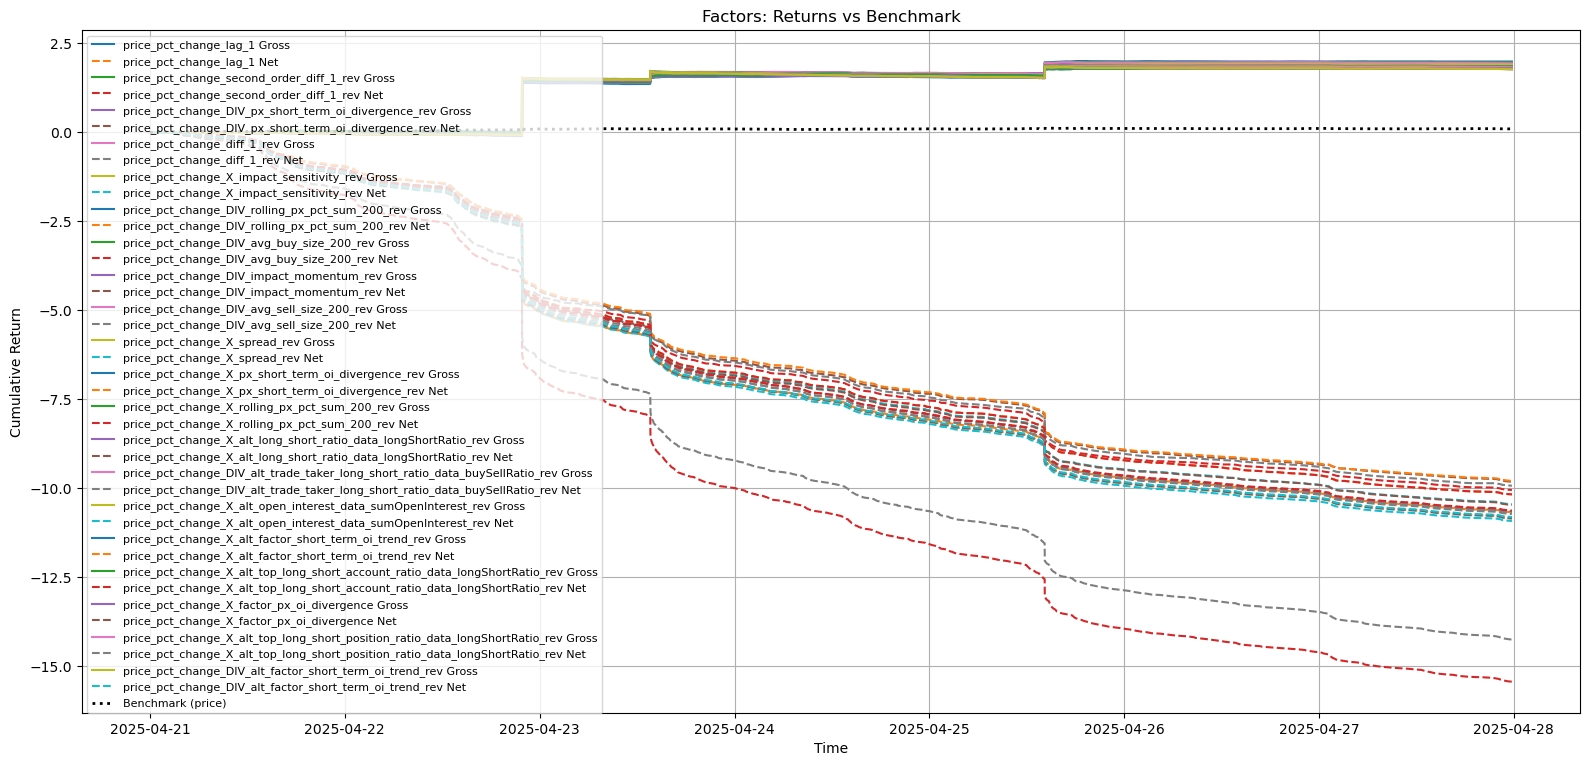

In [686]:
from tqdm import tqdm
import polars as pl
import matplotlib.pyplot as plt

cost_rate = 0.001  # 假设交易成本比例是0.05%
bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col
target_col_for_cal = f"future_return_{avg_steps_2pct}"

# 进一步排除字段名中包含 bug_col 任何一项作为子串的字段
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]


def gen_signal_expr(factor, reverse=False):
    q20 = df.select(pl.col(factor).quantile(0.5)).item()
    q80 = df.select(pl.col(factor).quantile(0.5)).item()
    signal_name = f"signal_{factor}_rev" if reverse else f"signal_{factor}"
    signal = (
        pl.when(pl.col(factor) > q80).then(1)
          .when(pl.col(factor) < q20).then(-1)
          .otherwise(0)
          .alias(signal_name)
    )
    if reverse:
        return (signal * -1).alias(signal_name)
    return signal


# signal_exprs = []
# for f in factors:
#     signal_exprs.append(gen_signal_expr(f, reverse=False))
#     signal_exprs.append(gen_signal_expr(f, reverse=True))

df_cum_sum = gen_signal_exprs_rolling(df, factors, window_size=500)
print(df_cum_sum)

for f in tqdm(factors, desc="Calculating strategy returns"):
    signal_col = f"signal_{f}"

    for mode in ["", "_rev"]:  # 空字符串是正向，_rev 是反向
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"
        cum_return_col = f"cum_strategy_return_{f}{mode}"
   
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col) * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias(strategy_return_col)
        ]).with_columns([
            pl.col(strategy_return_col).fill_null(0).cum_sum().alias(cum_return_col)
        ])

for f in tqdm(factors, desc="Calculating costs and net returns"):
      for mode in ["", "_rev"]:
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"

        position_change_col = f"{signal_col}_position_change"
        transaction_cost_col = f"{signal_col}_transaction_cost"
        net_return_col = f"net_return_{f}{mode}"
        cum_net_return_col = f"cum_net_return_{f}{mode}"
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col).diff().abs().fill_null(0)).alias(position_change_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(position_change_col) * cost_rate).alias(transaction_cost_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(strategy_return_col) - pl.col(transaction_cost_col)).alias(net_return_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            pl.col(net_return_col).fill_null(0).cum_sum().alias(cum_net_return_col)
        ])

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"cum_strategy_return_{f}" for f in factors] + [f"cum_strategy_return_{f}_rev" for f in factors]

# 排除不需要的因子
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# 获取最后一个时间点的净收益值
final_net_returns = df_cum_sum.select(net_return_cols).tail(1).to_dict(as_series=False)

# 根据最后收益排序
sorted_net_returns = sorted(final_gross_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:20]
topN_info = []
good_factors = []

for col_name, value in top20:
    is_reversed = col_name.endswith("_rev")
    # 去掉前缀和 _rev 后缀，得到纯净因子名
    clean_name = col_name.replace("cum_net_return_", "")
    if is_reversed:
        clean_name = clean_name.replace("_rev", "")
    topN_info.append({
        "raw_col": col_name,
        "factor": clean_name,
        "is_reversed": is_reversed,
        "final_return": value[0]
    })
    good_factors.append(clean_name)
    
print(top20)
# 提取列名、是否反转的标志
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_net_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_strategy_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))
# 开始画图
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # 检查列是否存在
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"⚠️ Missing column for factor {f} (rev={is_rev})")
        continue

    # 获取数据
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # 打印信息
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # 画图
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark 也采样一下
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [642]:
# 样例数据
values = [10, 20, 30, 40, 50]
import pandas as pd

df_pd = pd.DataFrame({"value": values})
df_pd["shift_1"] = df_pd["value"].shift(1)
import polars as pl

df_pl = pl.DataFrame({"value": values})
df_pl = df_pl.with_columns(
    shift_1 = pl.col("value").shift(1)
)

df_pd["rolling_3"] = df_pd["value"].rolling(3).mean()
df_pl = df_pl.with_columns(
    rolling_3 = pl.col("value").rolling_mean(window_size=3)
)
df_pl = df_pl.with_columns(
    lag_2 = pl.col("value").shift(2)
)
print("📦 Pandas:")
print(df_pd)

print("\n📦 Polars:")
print(df_pl)


📦 Pandas:
   value  shift_1  rolling_3
0     10      NaN        NaN
1     20     10.0        NaN
2     30     20.0       20.0
3     40     30.0       30.0
4     50     40.0       40.0

📦 Polars:
shape: (5, 4)
┌───────┬─────────┬───────────┬───────┐
│ value ┆ shift_1 ┆ rolling_3 ┆ lag_2 │
│ ---   ┆ ---     ┆ ---       ┆ ---   │
│ i64   ┆ i64     ┆ f64       ┆ i64   │
╞═══════╪═════════╪═══════════╪═══════╡
│ 10    ┆ null    ┆ null      ┆ null  │
│ 20    ┆ 10      ┆ null      ┆ null  │
│ 30    ┆ 20      ┆ 20.0      ┆ 10    │
│ 40    ┆ 30      ┆ 30.0      ┆ 20    │
│ 50    ┆ 40      ┆ 40.0      ┆ 30    │
└───────┴─────────┴───────────┴───────┘


In [658]:
import polars as pl

# === 模拟数据 ===
df = pl.DataFrame({
    "price": [100, 101, 102, 101, 100, 98, 99, 100],
    "signal": [0, 1, 1, 0, -1, -1, 0, 1],  # 预设的信号
})

# === 设置参数 ===
cost_rate = 0.001  # 假设交易成本为 0.1%

# === 计算策略收益 ===
df = df.with_columns([
    # 收益 = 当期 signal × (下期价格变化)
    (pl.col("signal") * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias("strategy_return"),
    
    # 仓位变化（绝对值）用于计算换仓成本
    pl.col("signal").diff().abs().fill_null(0).alias("position_change"),
])

df = df.with_columns([
    # 成本 = position_change × 成本率
    (pl.col("position_change") * cost_rate).alias("transaction_cost"),
    ]).with_columns([

    # 净收益 = 策略收益 - 成本
    (pl.col("strategy_return") - pl.col("transaction_cost")).alias("net_return"),
    
    # 累计收益
    pl.col("strategy_return").fill_null(0).cum_sum().alias("cum_strategy_return"),
    ]).with_columns([
    pl.col("net_return").fill_null(0).cum_sum().alias("cum_net_return"),
])

# === 打印结果 ===
print(df)


shape: (8, 8)
┌───────┬────────┬─────────────────┬─────────────────┬──────────────────┬────────────┬─────────────────────┬────────────────┐
│ price ┆ signal ┆ strategy_return ┆ position_change ┆ transaction_cost ┆ net_return ┆ cum_strategy_return ┆ cum_net_return │
│ ---   ┆ ---    ┆ ---             ┆ ---             ┆ ---              ┆ ---        ┆ ---                 ┆ ---            │
│ i64   ┆ i64    ┆ f64             ┆ i64             ┆ f64              ┆ f64        ┆ f64                 ┆ f64            │
╞═══════╪════════╪═════════════════╪═════════════════╪══════════════════╪════════════╪═════════════════════╪════════════════╡
│ 100   ┆ 0      ┆ 0.0             ┆ 0               ┆ 0.0              ┆ 0.0        ┆ 0.0                 ┆ 0.0            │
│ 101   ┆ 1      ┆ 0.009901        ┆ 1               ┆ 0.001            ┆ 0.008901   ┆ 0.009901            ┆ 0.008901       │
│ 102   ┆ 1      ┆ -0.009804       ┆ 0               ┆ 0.0              ┆ -0.009804  ┆ 0.000097         

[('cum_net_return_oi_trend_slope_skew_rev', [0.032373364403002765]), ('cum_net_return_alt_factor_long_term_oi_trend_fft_power_top3', [0.02036203223231048]), ('cum_net_return_alt_open_interest_data_sumOpenInterestValue_fft_power_top3_rev', [0.01993097943875667]), ('cum_net_return_alt_top_long_short_account_ratio_data_longShortRatio_kalman', [0.01457226884997034]), ('cum_net_return_alt_factor_long_term_oi_trend_kalman', [0.0021943700148128274])]

==== Factor: oi_trend_slope_skew_rev ====
Net return head: [0. 0. 0. 0. 0.]
Net return tail: [0.03237336 0.03237336 0.03237336 0.03237336 0.03237336]
Net return max: 0.06129068559489293
Net return min: -0.006942060529740445
Final return: 0.032373364403002765

==== Factor: alt_factor_long_term_oi_trend_fft_power_top3 ====
Net return head: [0. 0. 0. 0. 0.]
Net return tail: [0.01978521 0.02034256 0.02086226 0.02036203 0.02036203]
Net return max: 0.0466726211264199
Net return min: -0.025151284025671017
Final return: 0.02036203223231048

==== Factor:

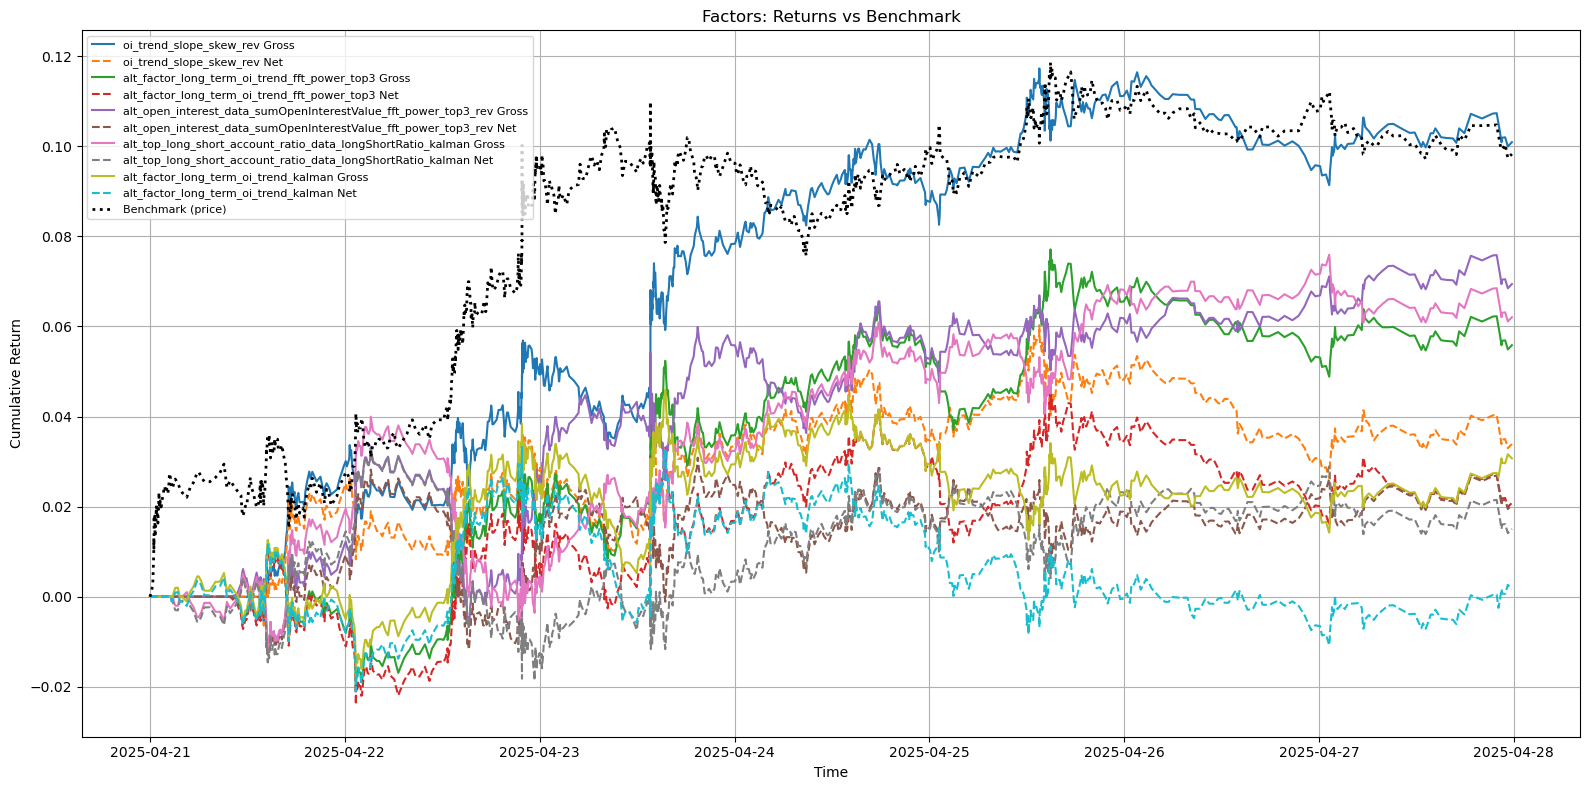

In [688]:

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"cum_strategy_return_{f}" for f in factors] + [f"cum_strategy_return_{f}_rev" for f in factors]

# 排除不需要的因子
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# 获取最后一个时间点的净收益值
final_net_returns = df_cum_sum.select(net_return_cols).tail(1).to_dict(as_series=False)

# 根据最后收益排序
sorted_net_returns = sorted(final_net_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:5]
topN_info = []
good_factors = []

for col_name, value in top20:
    is_reversed = col_name.endswith("_rev")
    # 去掉前缀和 _rev 后缀，得到纯净因子名
    clean_name = col_name.replace("cum_net_return_", "")
    if is_reversed:
        clean_name = clean_name.replace("_rev", "")
    topN_info.append({
        "raw_col": col_name,
        "factor": clean_name,
        "is_reversed": is_reversed,
        "final_return": value[0]
    })
    good_factors.append(clean_name)
    
print(top20)
# 提取列名、是否反转的标志
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_net_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_strategy_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
# 开始画图
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # 检查列是否存在
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"⚠️ Missing column for factor {f} (rev={is_rev})")
        continue

    # 获取数据
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # 打印信息
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # 画图
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark 也采样一下
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [796]:
import matplotlib.pyplot as plt

def plot_factor_comparison(df, factor_a: str, factor_b: str):
    cum_col_a = factor_a
    cum_col_b = factor_b
    time_col = df.columns[0]  # 假设第0列是时间戳，比如 'timestamp' 或 'date'

    plt.figure(figsize=(12, 6))
    plt.plot(df[time_col], df[cum_col_a], label=factor_a, linewidth=2)
    plt.plot(df[time_col], df[cum_col_b], label=factor_b, linewidth=2, linestyle="--")

    plt.title(f"Cumulative Strategy Return: {factor_a} vs {factor_b}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_factor_comparison(
    df,
    factor_a="change_side_kalman",
    factor_b="alt_factor_long_term_oi_trend_fft_power_top3"
)


ColumnNotFoundError: "change_side_kalman" not found

<Figure size 1200x600 with 0 Axes>

In [794]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd

def plot_rolling_vs_global_quantile_from_polars(
    pl_df: pl.DataFrame,
    factor: str,
    window: int = 50,
    quantiles=(0.1, 0.5, 0.9),
    global_colors=("red", "green", "blue"),  # 每个 global quantile 用不同颜色
    rolling_colors=("orange", "lime", "cyan")  # 可自定义 rolling 线颜色
):
    # 转成 pandas
    df = pl_df.to_pandas()
    time_col = df.columns[0]
    x = df[time_col]
    y = df[factor]

    plt.figure(figsize=(14, 6))
    plt.plot(x, y, label=factor, color="black", alpha=0.4)

    # global quantiles 横线
    for i, q in enumerate(quantiles):
        q_val = y.quantile(q)
        plt.axhline(q_val, linestyle='--', color=global_colors[i], alpha=0.7,
                    label=f'Global Q{q:.1f}: {q_val:.2f}')

    # rolling quantiles 曲线
    for i, q in enumerate(quantiles):
        rolling_q = y.rolling(window=window).quantile(q)
        plt.plot(x, rolling_q, label=f'Rolling Q{q:.1f}', linewidth=2, color=rolling_colors[i])

    plt.title(f"{factor}: Rolling vs Global Quantiles (window={window})")
    plt.xlabel("Time")
    plt.ylabel("Factor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rolling_vs_global_quantile_from_polars(
    pl_df=df,
    factor="change_side_kalman",
    window=500,
    quantiles=(0.1, 0.5, 0.9),
    global_colors=("red", "green", "blue"),
    rolling_colors=("pink", "lime", "skyblue")
)


KeyError: 'change_side_kalman'

In [254]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    return mean_excess_return / std_excess_return


In [698]:
def gen_signal_exprs_rolling(df: pl.DataFrame, factors: list[str], window_size=500):
    exprs_group_a = []
    exprs_group_b = []

    for factor in factors:
        up_temp = f"{factor}_up_temp"
        dn_temp = f"{factor}_dn_temp"

        # 计算 rolling quantiles
        exprs_group_a.extend([
            pl.col(factor).rolling_quantile(0.51, "nearest", window_size).alias(up_temp),
            pl.col(factor).rolling_quantile(0.49, "nearest", window_size).alias(dn_temp),
        ])

        # 正向 signal
        signal_col = f"signal_{factor}"
        exprs_group_b.append(
            pl.when(pl.col(factor) > pl.col(up_temp)).then(1)
            .when(pl.col(factor) < pl.col(dn_temp)).then(-1)
            .otherwise(0)
            .fill_null(0)
            .alias(signal_col)
        )

        # 反向 signal
        signal_rev_col = f"signal_{factor}_rev"
        exprs_group_b.append(
            pl.when(pl.col(factor) > pl.col(up_temp)).then(-1)
            .when(pl.col(factor) < pl.col(dn_temp)).then(1)
            .otherwise(0)
            .fill_null(0)
            .alias(signal_rev_col)
        )

    df = df.with_columns(exprs_group_a).with_columns(exprs_group_b)
    
    drop_cols = [f"{factor}_up_temp" for factor in factors] + [f"{factor}_dn_temp" for factor in factors]
    df = df.drop(drop_cols)

    return df

xs = gen_signal_exprs_rolling(df, factors, window_size=500)
print(xs)

shape: (11_757, 10_837)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… ┆ signal_oi_long_breakout_signal… │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---                             ┆ ---                             ┆ ---                             ┆ ---                             │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ i32                             ┆ i32                             ┆ i32                             ┆ i32                             │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═

In [734]:
def gen_signal_expr(factor, reverse=False):
    q20 = df.select(pl.col(factor).quantile(0.8)).item()
    q80 = df.select(pl.col(factor).quantile(0.2)).item()
    signal_name = f"signal_{factor}_rev" if reverse else f"signal_{factor}"
    signal = (
        pl.when(pl.col(factor) > q80).then(1)
          .when(pl.col(factor) < q20).then(-1)
          .otherwise(0)
          .alias(signal_name)
    )
    if reverse:
        return (signal * -1).alias(signal_name)
    return signal


signal_exprs = []
for f in factors:
    signal_exprs.append(gen_signal_expr(f, reverse=False))
    signal_exprs.append(gen_signal_expr(f, reverse=True))

xs = df.with_columns(signal_exprs)
print(xs)

shape: (11_757, 8_765)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ signal_impact_sensitivity_DIV_… ┆ signal_impact_sensitivity_DIV_… ┆ signal_impact_sensitivity_SPRE… ┆ signal_impact_sensitivity_SPRE… │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---                             ┆ ---                             ┆ ---                             ┆ ---                             │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ i32                             ┆ i32                             ┆ i32                             ┆ i32                             │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══

In [758]:
def compute_signals_and_returns(df: pl.DataFrame, factors: list[str], cost_rate=0.0005) -> pl.DataFrame:
    signal_exprs = []

    # ✅ 一次性生成所有信号表达式
    for f in factors:
        signal_exprs += [gen_signal_expr(f, False), gen_signal_expr(f, True)]

    # ✅ 一次性添加所有 signal 列
    df = df.with_columns(signal_exprs)

    # ✅ 对每个因子（正向 + 反向）处理收益、成本等
    exprs_group_a = []
    exprs_group_b = []
    exprs_group_c = []
    exprs_group_d = []

    for f in tqdm(factors, desc="Computing returns"):
        for mode in ["", "_rev"]:
            signal_col = f"signal_{f}{mode}"
            strat_ret_col = f"strategy_return_{f}{mode}"
            cum_ret_col = f"cum_strategy_return_{f}{mode}"

            pos_change_col = f"{signal_col}_position_change"
            cost_col = f"{signal_col}_transaction_cost"
            net_ret_col = f"net_return_{f}{mode}"
            cum_net_ret_col = f"cum_net_return_{f}{mode}"

            exprs_group_a += [
                (pl.col(signal_col) * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias(strat_ret_col),
                pl.col(signal_col).diff().abs().fill_null(0).alias(pos_change_col),
            ]
            
            exprs_group_b += [
                (pl.col(pos_change_col) * cost_rate).alias(cost_col),
                pl.col(strat_ret_col).fill_null(0).cum_sum().alias(cum_ret_col),
            ]

            exprs_group_c += [
                (pl.col(strat_ret_col) - pl.col(cost_col)).alias(net_ret_col),
            ]
            exprs_group_d += [
                pl.col(net_ret_col).fill_null(0).cum_sum().alias(cum_net_ret_col),

            ]

    # ✅ 一次性应用所有表达式
    df = df.with_columns(exprs_group_a).with_columns(exprs_group_b).with_columns(exprs_group_c).with_columns(exprs_group_d)

    return df

In [736]:
def rank_factors_by_gross(df: pl.DataFrame, factors: list[str], plot_top_n=20, sort_by="final_return"):
    factor_stats = []
    for f in tqdm(factors, desc="Ranking factors by gross return"):
        for mode in ["", "_rev"]:
            suffix = f"{f}{mode}"
            cum_gross_col = f"cum_net_return_{suffix}"
            if cum_gross_col not in df.columns:
                continue
            cum_returns = df[cum_gross_col].to_numpy()
            if len(cum_returns) < 2:
                continue
            sharpe = sharpe_ratio_non_annualized(np.diff(cum_returns, prepend=0))
            final_return = cum_returns[-1]
            factor_stats.append({
                "factor": f,
                "mode": mode,
                "gross_col": cum_gross_col,
                "sharpe": sharpe,
                "final_return": final_return,
            })

    sorted_stats = sorted(factor_stats, key=lambda x: x[sort_by], reverse=True)
    top_stats = sorted_stats[:plot_top_n]

    top_factors_by_gross = [f"{item['factor']}{item['mode']}" for item in top_stats]
    sharpe_by_factor = {f"{item['factor']}{item['mode']}": item["sharpe"] for item in top_stats}
    gross_by_factor = {f"{item['factor']}{item['mode']}": item["final_return"] for item in top_stats}

    return top_factors_by_gross, sharpe_by_factor, gross_by_factor


In [737]:
bug_col = [
    "strategy_return_", "cum_strategy_return_", "signal_",
    "position_", "position_change_", "sharpe_", "gross_", "net_",
    "price_pct_change", "ret_1", "change_side", "momentum_confirmed_by_orderflow",
    "trades_side",
    
]

exclude_contains = [
    "ret_mean_10", "ret_mean_5", "ret_1_lag",
    "position_", "position_change_", "sharpe_", "gross_", "net_",
    "price_pct_change", "ret_1", "change_side",
    "momentum_confirmed_by_orderflow", "trades_side",
    "rolling_px_pct_sum", "px_short_oi_divergence"
]

exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col
target_col_for_cal = f"future_return_{avg_steps_2pct}"

# 进一步排除字段名中包含 bug_col 任何一项作为子串的字段
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and not col.startswith("signal_")
    and not col.startswith("momentum_confirmed_by_orderflow")
    and not col.startswith("ret_mean_5")
    and not col.startswith("ret_mean_10")
    and not any(keyword in col for keyword in exclude_contains)

    and col != "price"
]

df_with_signals = gen_signal_exprs_rolling(df, factors, window_size=500)
print(df_with_signals)

df_cum_sum = compute_signals_and_returns(df_with_signals, factors)
top_factors_by_gross, sharpe_by_factor, gross_by_factor = rank_factors_by_gross(df_cum_sum, factors)

print("Top Factors by Gross Return:", top_factors_by_gross, sharpe_by_factor, gross_by_factor)
print("Sharpe Ratios (non-annualized):")
for k, v in sharpe_by_factor.items():
    print(f"{k}: {v:.4f}")


shape: (11_757, 8_765)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ signal_impact_sensitivity_DIV_… ┆ signal_impact_sensitivity_DIV_… ┆ signal_impact_sensitivity_SPRE… ┆ signal_impact_sensitivity_SPRE… │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---                             ┆ ---                             ┆ ---                             ┆ ---                             │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ i32                             ┆ i32                             ┆ i32                             ┆ i32                             │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪══

Ranking factors by gross return: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2521/2521 [00:14<00:00, 171.51it/s]

Top Factors by Gross Return: ['real_bid_amount_sum_volatility_200', 'alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue', 'alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_fft_power_top3', 'alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_volatility_200', 'alt_trade_taker_long_short_ratio_data_buySellRatio_X_avg_buy_size_200', 'avg_buy_size_200_kalman', 'best_bid_amount_kalman', 'avg_buy_size_200_X_avg_sell_size_200', 'alt_open_interest_data_sumOpenInterestValue_X_avg_buy_size_200', 'avg_buy_size_200_lag_1', 'alt_open_interest_data_sumOpenInterest_X_avg_sell_size_200', 'alt_top_long_short_account_ratio_data_longShortRatio_X_avg_sell_size_200', 'alt_long_short_ratio_data_longShortRatio_X_avg_sell_size_200', 'avg_buy_size_200', 'avg_buy_size_200_squared', 'avg_buy_size_200_abs', 'avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence', 'avg_buy_size_200_SPREAD_X_MAG_impact_sensitivi

In [738]:
print("Top Factors by Gross Return:", top_factors_by_gross)
print("Sharpe Ratios (non-annualized):")

for k, v in sharpe_by_factor.items():
    print(f"{k}: {v:.4f}")

print("============================")
for k, v in gross_by_factor.items():
    print(f"{k}: {v:.4f}")


Top Factors by Gross Return: ['real_bid_amount_sum_volatility_200', 'alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue', 'alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_fft_power_top3', 'alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_volatility_200', 'alt_trade_taker_long_short_ratio_data_buySellRatio_X_avg_buy_size_200', 'avg_buy_size_200_kalman', 'best_bid_amount_kalman', 'avg_buy_size_200_X_avg_sell_size_200', 'alt_open_interest_data_sumOpenInterestValue_X_avg_buy_size_200', 'avg_buy_size_200_lag_1', 'alt_open_interest_data_sumOpenInterest_X_avg_sell_size_200', 'alt_top_long_short_account_ratio_data_longShortRatio_X_avg_sell_size_200', 'alt_long_short_ratio_data_longShortRatio_X_avg_sell_size_200', 'avg_buy_size_200', 'avg_buy_size_200_squared', 'avg_buy_size_200_abs', 'avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence', 'avg_buy_size_200_SPREAD_X_MAG_impact_sensitivi

⚠️ Missing column for factor cum_net_return_real_bid_amount_sum_volatility_200 (rev=False)
⚠️ Missing column for factor cum_net_return_alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue (rev=False)
⚠️ Missing column for factor cum_net_return_alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope (rev=False)
⚠️ Missing column for factor cum_net_return_best_bid_amount_fft_power_top3 (rev=False)
⚠️ Missing column for factor cum_net_return_alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope (rev=False)


ValueError: x and y must have same first dimension, but have shapes (11757,) and (1176,)

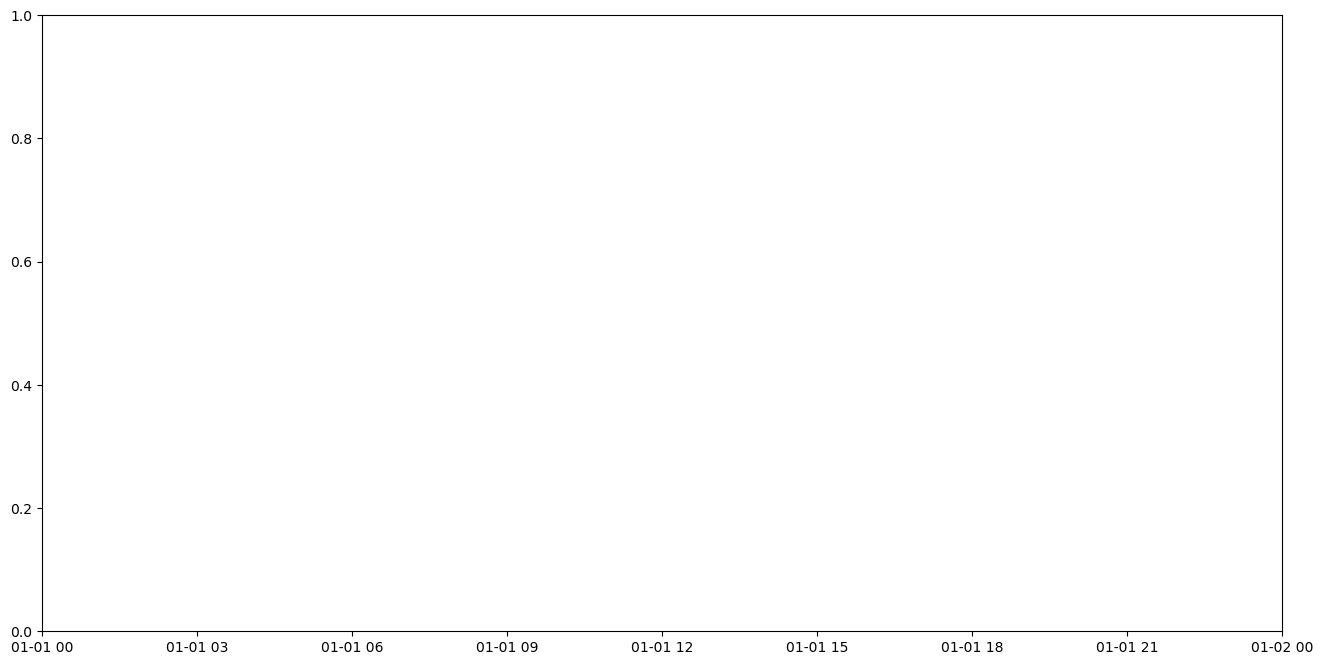

In [770]:

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"strategy_return_{f}" for f in factors] + [f"strategy_return_{f}_rev" for f in factors]

# 排除不需要的因子
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

selected_cols = [
    'cum_net_return_far_ask_price_fft_power_top3',
    'cum_net_return_alt_open_interest_data_sumOpenInterest_DIV_oi_short_breakout_signal_rev',
    'cum_net_return_far_bid_price_fft_power_top3_rev',
    'cum_net_return_mid_price_fft_power_top3_rev',
    'cum_net_return_far_ask_price_fft_power_top3_rev',  # 假设你刚好要这几个
]
df_cum_sum.drop_nulls()

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# 获取最后一个时间点的净收益值
final_net_returns = df_cum_sum.select(net_return_cols).tail(2).to_dict(as_series=False)
# 根据最后收益排序
sorted_net_returns = sorted(final_net_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:5]
topN_info = []
good_factors = []

# for col_name, value in top20:
#     is_reversed = col_name.endswith("_rev")
#     # 去掉前缀和 _rev 后缀，得到纯净因子名
#     clean_name = col_name.replace("cum_net_return_", "")
#     if is_reversed:
#         clean_name = clean_name.replace("_rev", "")
#     topN_info.append({
#         "raw_col": col_name,
#         "factor": clean_name,
#         "is_reversed": is_reversed,
#         "final_return": value[0]
#     })
#     good_factors.append(clean_name)
    
# print(top20)
# 提取列名、是否反转的标志
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_net_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_strategy_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))

# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("strategy_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("strategy_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
# 开始画图
# 开始画图
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # 检查列是否存在
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"⚠️ Missing column for factor {f} (rev={is_rev})")
        continue

    # 获取数据
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # 打印信息
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # 画图
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark 也采样一下
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


==== Factor: impact_price_pct_bid_imn ====
Net return head: [ 5.28243415e-04  1.03210163e-03  5.29164500e-04  2.41311974e-05
 -5.15864271e-04]
Net return tail: [-4.33185624 -4.33341359 -4.33393328 -4.33343306 -4.33443306]
Final net return: -4.334433061356983
Signal × Price return tail: [-2.07336183 -2.07284212 -2.07339947 -2.07391916 -2.07441939]
Final signal × price return: -2.074419387942087

==== Factor: spread ====
Net return head: [-0.00052824 -0.00102439 -0.00152732 -0.00203236 -0.00257235]
Net return tail: [-3.38576254 -3.38631989 -3.38683958 -3.38633936 -3.38633936]
Final net return: -3.386339357123177
Signal × Price return tail: [0.02118961 0.02170932 0.02115197 0.02063228 0.0211325 ]
Final signal × price return: 0.021132502829651734

==== Factor: best_ask_amount ====
Net return head: [-0.00052824 -0.0010321  -0.00052916 -0.0020342  -0.0024942 ]
Net return tail: [-3.01755602 -3.01699867 -3.01851836 -3.01801814 -3.01901814]
Final net return: -3.0190181367501485
Signal × Price 

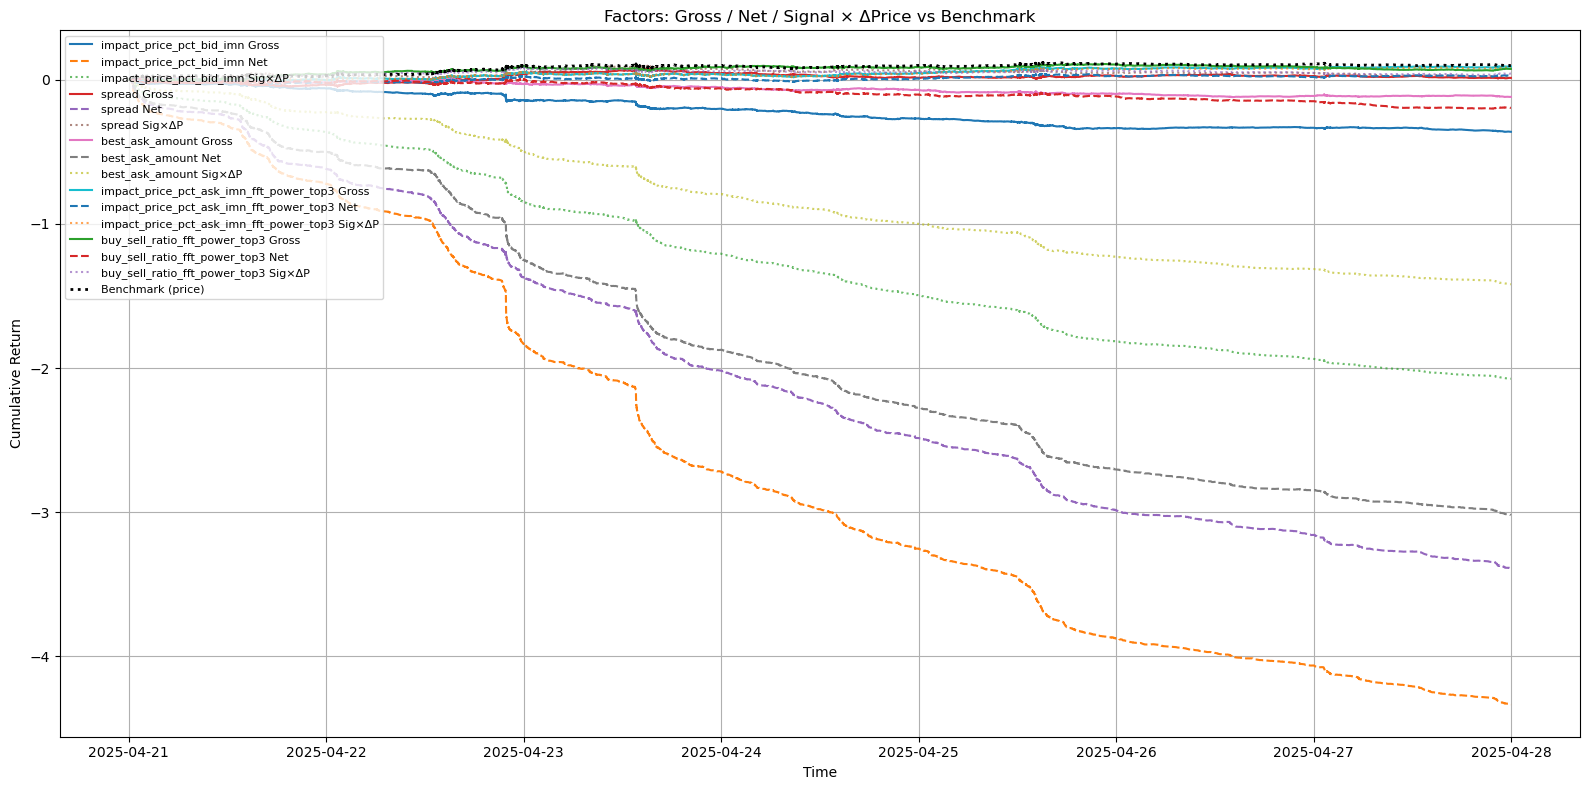

In [766]:
plt.figure(figsize=(16, 8))
step = 1

price = df_cum_sum["price"]
price_change = (price / price.shift(1) - 1).fill_null(0)

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    if any(col not in df_cum_sum.columns for col in [gross_col, net_col, signal_col]):
        print(f"⚠️ Missing column for factor {f} (rev={is_rev})")
        continue

    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()
    signal_arr = df_cum_sum[signal_col].fill_null(0).to_numpy()
    sig_price_return_arr = (signal_arr * price_change.to_numpy()).astype(float)
    cum_sig_price_return = np.cumsum(sig_price_return_arr)

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)
        cum_sig_price_return = np.clip(cum_sig_price_return, a_min=0, a_max=None)

    print(f"\n==== Factor: {f}{suffix} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Final net return:", net_arr[-1])
    print("Signal × Price return tail:", cum_sig_price_return[-5:])
    print("Final signal × price return:", cum_sig_price_return[-1])

    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    sig_price_sampled = cum_sig_price_return[::step]

    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")
    plt.plot(time_sampled, sig_price_sampled, label=f"{f}{suffix} Sig×ΔP", linestyle=":", alpha=0.7)  # ⭐ 新增图

# benchmark
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]

plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Gross / Net / Signal × ΔPrice vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


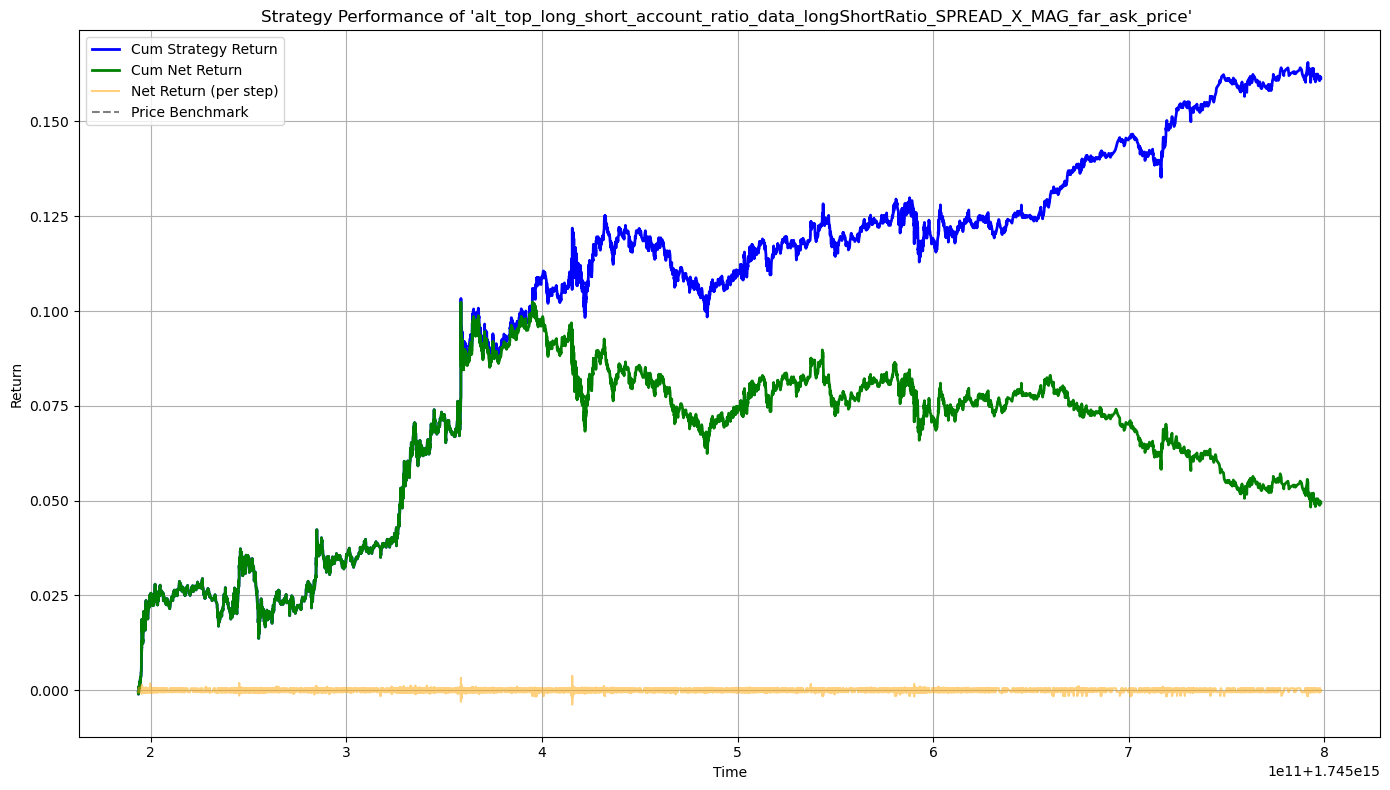

In [774]:
import matplotlib.pyplot as plt
import polars as pl

def plot_strategy_performance(df: pl.DataFrame, factor: str, reversed: bool = False):
    mode = "_rev" if reversed else ""
    signal_col = f"signal_{factor}{mode}"
    strat_col = f"strategy_return_{factor}{mode}"
    cum_strat_col = f"cum_strategy_return_{factor}{mode}"
    net_ret_col = f"net_return_{factor}{mode}"
    cum_net_col = f"cum_net_return_{factor}{mode}"
    time_col = df.columns[0]  # 默认第0列是时间戳
    price_col = "price"       # 假设 benchmark 是价格

    # 转成 pandas，便于画图
    pdf = df.select([
        time_col,
        price_col,
        strat_col,
        cum_strat_col,
        net_ret_col,
        cum_net_col
    ]).to_pandas()

    # 归一化 benchmark price
    price_return_arr = (pdf["price"] / pdf["price"].shift(1) - 1).to_numpy()
    pdf["price_benchmark"] = np.cumsum(price_return_arr)

    plt.figure(figsize=(14, 8))

    plt.plot(pdf[time_col], pdf[cum_strat_col], label="Cum Strategy Return", color="blue", linewidth=2)
    plt.plot(pdf[time_col], pdf[cum_net_col], label="Cum Net Return", color="green", linewidth=2)
    plt.plot(pdf[time_col], pdf[net_ret_col], label="Net Return (per step)", color="orange", alpha=0.5)
    plt.plot(pdf[time_col], pdf["price_benchmark"], label="Price Benchmark", color="gray", linestyle="--")

    plt.title(f"Strategy Performance of '{factor}' {'(Reversed)' if reversed else ''}")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_strategy_performance(df_cum_sum, factor="alt_top_long_short_account_ratio_data_longShortRatio_SPREAD_X_MAG_far_ask_price", reversed=False)

# 若你想画反向信号的效果：


In [745]:
print(df["impact_sensitivity_diff_1"])

shape: (11_757,)
Series: 'impact_sensitivity_diff_1' [f64]
[
	null
	-0.00007
	0.000004
	0.000119
	0.000342
	…
	-0.000002
	0.000005
	-0.000005
	-3.5658e-7
	-0.000015
]


In [416]:
f = 'spread_skew'
print(df_cum_sum.select([
    f,
    f"signal_{f}",
    f"strategy_return_{f}",
    f"cum_strategy_return_{f}"
]).tail(10))


shape: (10, 4)
┌─────────────┬────────────────────┬─────────────────────────────┬─────────────────────────────────┐
│ spread_skew ┆ signal_spread_skew ┆ strategy_return_spread_skew ┆ cum_strategy_return_spread_ske… │
│ ---         ┆ ---                ┆ ---                         ┆ ---                             │
│ f64         ┆ i32                ┆ f64                         ┆ f64                             │
╞═════════════╪════════════════════╪═════════════════════════════╪═════════════════════════════════╡
│ 12.096145   ┆ 1                  ┆ -0.000503                   ┆ 0.045056                        │
│ 12.096263   ┆ 1                  ┆ -0.0005                     ┆ 0.044555                        │
│ 12.096376   ┆ 1                  ┆ 0.000501                    ┆ 0.045056                        │
│ 12.096484   ┆ 1                  ┆ 0.000502                    ┆ 0.045558                        │
│ 12.096588   ┆ 1                  ┆ -0.0005                     ┆ 0.045057 

In [ ]:
names = [item[0] for item in top20]
names

In [ ]:
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")


In [ ]:
import pandas as pd

returns = pd.Series(np.diff(cum_returns))
autocorr = returns.autocorr(lag=100)
print(f"Autocorrelation of returns (lag=1): {autocorr:.4f}")


In [298]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    sharpe = mean_excess_return / std_excess_return
    return sharpe


sharpe = sharpe_ratio_non_annualized(cum_returns)

print(f"Non-annualized Sharpe Ratio: {sharpe:.4f}")


NameError: name 'cum_returns' is not defined

In [ ]:
df

In [ ]:
ic_rank = good_factors      # 假设：根据 IC 值排名靠前的因子
sharpe_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_best_bid_price',]   # 假设：基于因子组合夏普率排序
cumret_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_best_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_bid_price']   # 假设：基于因子组合累计收益排序
ir_rank =[]     # 假设：根据 IC 值排名靠前的因子

bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col

# 进一步排除字段名中包含 bug_col 任何一项作为子串的字段
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes) 
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]
target_col_for_cal = f"future_return_{avg_steps_2pct}"


In [ ]:
# 创建统一的“保留因子”集合（任意一个榜单入选就保留）
keep_set = set(ic_rank) | set(ir_rank) | set(sharpe_rank) | set(cumret_rank)
# 用 list 推导生成新因子池
filtered_factors = [f for f in factors if f in keep_set]

# 可选：打印保留了多少
print(f"保留因子数：{len(filtered_factors)} / 原始因子数：{len(factors)}")

# 可选：提取出新的 Polars 子 DataFrame
filtered_df = df.select(filtered_factors + [target_col_for_cal])  # 加上目标列方便后续建模


In [ ]:
rank_weights = {
    "ic": 1.2,
    "ir": 1.0,
    "sharpe": 1.2,
    "cumret": 1.5,
}

# 每个因子打分
from collections import defaultdict

score = defaultdict(float)
for f in ic_rank:
    score[f] += rank_weights["ic"]
for f in ir_rank:
    score[f] += rank_weights["ir"]
for f in sharpe_rank:
    score[f] += rank_weights["sharpe"]
for f in cumret_rank:
    score[f] += rank_weights["cumret"]

# 只保留分数大于一定阈值的因子
filtered_factors = [f for f in factors if score[f] >= 1.0]
print(filtered_factors)

In [ ]:
def pl_dropna(df: pl.DataFrame) -> pl.DataFrame:

    pdf = df.to_pandas()
    pdf_clean = pdf.dropna()
    return pl.from_pandas(pdf_clean)

In [ ]:
def filter_by_spearman_corr(df: pl.DataFrame, factor_cols: list[str], threshold: float = 0.9) -> list[str]:
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    
    corr_matrix, _ = spearmanr(matrix)  # 一次性计算所有因子的 Spearman 相关系数矩阵，shape = (n, n)
    n = len(factor_cols)
    keep = []
    removed = set()
    
    print("Spearman correlation matrix:")
    print(np.round(corr_matrix, 3))
    
    for i in range(n):
        if factor_cols[i] in removed:
            # print(f"Skip {factor_cols[i]} as it is removed")
            continue
        keep.append(factor_cols[i])
        # print(f"Keep {factor_cols[i]}")
        
        for j in range(i+1, n):
            if factor_cols[j] in removed:
                continue

            corr_value = corr_matrix[i, j]

            if abs(corr_value) >= threshold:
                removed.add(factor_cols[j])
                # print(f"Remove {factor_cols[j]} because corr({factor_cols[i]}, {factor_cols[j]}) = {corr_value:.3f} >= {threshold}")

    return keep


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    """
    根据互信息保留前 top_k 个和目标变量相关性最强的因子。

    Args:
        df: Polars DataFrame
        factor_cols: 原始因子列
        target_col: 目标收益列
        top_k: 保留前 k 个因子

    Returns:
        保留的因子列名列表
    """
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected


In [ ]:
f_df = df.select(filtered_factors + [target_col_for_cal]).drop_nulls()
f_df

In [ ]:
# 第一步：先用 spearman 过滤冗余
low_corr_factors = filter_by_spearman_corr(f_df, factor_cols=filtered_factors, threshold=0.95)

# 第二步：再用 MI 选出前 k 个信息量最大的因子
final_selected_factors = filter_by_mutual_info(f_df, low_corr_factors, target_col=target_col_for_cal, top_k=30)


In [ ]:
print(low_corr_factors)
print(final_selected_factors)
# ['alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio']
# ['alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

def plot_spearman_corr_heatmap(df: pl.DataFrame, factor_cols: list[str], max_len: int = 20):
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    corr_matrix, _ = spearmanr(matrix)

    # 截断长名称
    short_names = [name if len(name) <= max_len else name[:max_len-3] + "..." for name in factor_cols]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix,
                xticklabels=short_names,
                yticklabels=short_names,
                cmap='cool',
                center=0,
                annot=False,
                square=True,
                cbar_kws={"shrink": .8})

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.title("Spearman Correlation Heatmap (Short Names)")
    plt.tight_layout()
    plt.show()
    print("corr_matrix max:", np.max(corr_matrix))
    print("corr_matrix min:", np.min(corr_matrix))
    print("corr_matrix mean:", np.mean(corr_matrix))

plot_spearman_corr_heatmap(f_df, final_selected_factors)

In [ ]:
df = df.drop_nulls()
df